In [70]:
import pandas as pd
import random
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import seaborn as sns
import re
import pickle

In [2]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\raiom.LAPTOP-
[nltk_data]     59QT21KS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\raiom.LAPTOP-
[nltk_data]     59QT21KS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
if torch.cuda.is_available():       
    device = torch.device("cuda")
    # print('There are %d GPU(s) available.' % torch.cuda.device_count())
    # print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    # print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [4]:
import transformers
# from transformers import LongformerTokenizer, LongformerForSequenceClassification
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, AdamW, BertConfig
from transformers.optimization import get_linear_schedule_with_warmup

In [5]:
dataframe = pd.read_csv(r"augmented_news_articles.csv")

In [6]:
# dataframe.head()

In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6138 entries, 0 to 6137
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   text_without_stopwords  6138 non-null   object
 1   label                   6138 non-null   object
dtypes: object(2)
memory usage: 96.0+ KB


In [8]:
# dataframe.isnull().sum()

In [9]:
# dataframe.dropna(inplace = True)

In [10]:
# dataframe['label'].value_counts()

In [11]:
# dataframe['type'].value_counts()

In [12]:
dataframe.duplicated().value_counts()

False    6102
True       36
Name: count, dtype: int64

In [13]:
# dataframe['language'].value_counts()

In [14]:
# dataframe = dataframe[dataframe['language'] == 'english'].reset_index(drop = True)

In [15]:
# dataframe.info()

In [16]:
dataframe.duplicated().value_counts()

False    6102
True       36
Name: count, dtype: int64

In [17]:
dataframe = dataframe.drop_duplicates().reset_index(drop = True)

In [18]:
dataframe.duplicated().value_counts()

False    6102
Name: count, dtype: int64

In [19]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6102 entries, 0 to 6101
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   text_without_stopwords  6102 non-null   object
 1   label                   6102 non-null   object
dtypes: object(2)
memory usage: 95.5+ KB


In [20]:
# missing_text_indices = dataframe[dataframe['text'].isna()].index.tolist()
# print(missing_text_indices)

In [21]:
# print(dataframe['text'].loc[1958])

In [22]:
# pattern = re.compile(r'[!@#$(),\n"%^*?\:;~0-9\[\]]')
# data_list = []

# def remove_stop_words(text):
#     data_list.clear()
#     words = text.split()
#     for word in words:
#         new_word = pattern.sub('', word).lower().strip()
#         if new_word and new_word not in stop_words:
#             data_list.append(new_word)
#     return ' '.join(data_list)

In [23]:
# for i in range(1958, 1961):
#     data  = dataframe['text'].loc[i]
#     text_without_stopwords = remove_stop_words(data)
#     dataframe.at[i, 'text_without_stopwords'] = text_without_stopwords

In [24]:
# dataframe.info()

In [25]:
# df = dataframe.drop(columns = ['author', 'published', 'title', 'text','title_without_stopwords', 'type', 'language', 'main_img_url', 'hasImage', 'site_url'])

In [26]:
# df.info()

In [27]:
# df.dropna(inplace = True)

In [28]:
# df.info()

In [29]:
# df['label'] = df['label'].map({'Fake': 1, 'Real':0})
dataframe['label'] = dataframe['label'].map({'Fake':1, 'Real':0})

In [30]:
# import spacy

# nlp = spacy.load('en_core_web_sm')

# def lemmatize_text(text):
#     doc = nlp(text)
#     return " ".join([token.lemma_ for token in doc])

# df['text_without_stopwords'] = df['text_without_stopwords'].apply(lemmatize_text)

In [31]:
# from nltk.stem import PorterStemmer

# stemmer = PorterStemmer()

# def stem_words(tokens):
#     return [stemmer.stem(word) for word in tokens]

In [32]:
# df['text_without_stopwords'] = df['text_without_stopwords'].apply(stem_words)

In [33]:
dataframe['text_without_stopowords'] = dataframe['text_without_stopwords'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))

In [34]:
dataframe['text_without_stopwords'] = dataframe['text_without_stopwords'].apply(lambda x: re.sub(r'(plead the fifth|corrupt to the core)', '', x, flags=re.IGNORECASE))

In [76]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case = True)
tokenizer.save_pretrained('utils/models/tokenizer')
# tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096', do_lower_case = True)

('utils/models/tokenizer\\tokenizer_config.json',
 'utils/models/tokenizer\\special_tokens_map.json',
 'utils/models/tokenizer\\vocab.txt',
 'utils/models/tokenizer\\added_tokens.json')

In [36]:
X_train, X_test = train_test_split(dataframe, test_size=0.2, random_state = 45)

In [37]:
texts = X_train['text_without_stopwords']

In [38]:
# max_len_title = 0
# for title in titles:
#     input_ids = tokenizer.encode(title,  add_special_tokens = True)
#     max_len_title = max(max_len_title, len(input_ids))
# # print('Max sentence length:', max_len_title)

In [39]:
def sliding_window_tokenization(text, tokenizer, max_length=512, stride=128):

    encoded_chunks = tokenizer(
        text,
        max_length=max_length,
        truncation=True,
        stride=stride,
        return_overflowing_tokens=True,
        return_tensors="pt",
        return_attention_mask = True,
        padding='max_length'
    )
    
    return encoded_chunks
# def longformer_tokenization(text, tokenizer, max_length = 4096):
#     encoded_chunks = tokenizer(
#         text,
#         max_length = max_length,
#         truncations = True,
#         padding = 'max_length',
#         return_tensors = 'pt',
#         return_attention_masks = True
#     )
#     return encoded_chunks

In [40]:
input_ids_texts = []
attention_masks_texts = []

In [41]:
# for title in titles:
#     encoded_dict = tokenizer.encode_plus(
#                         title,
#                         add_special_tokens = True,
#                         max_length = max_len_title,
#                         padding = 'max_length',
#                         truncation = True,
#                         return_attention_mask = True,
#                         return_tensors = 'pt'
#                 )
#     input_ids_titles.append(encoded_dict['input_ids'])
#     attention_masks_titles.append(encoded_dict['attention_mask'])

# input_ids_titles = torch.cat(input_ids_titles, dim = 0)
# attention_masks_titles = torch.cat(attention_masks_titles, dim = 0)

In [42]:
# replicated_titles = []
# replicated_masks = []
def tokenization(texts, input_ids_texts, attention_masks_texts):
    for i, text in enumerate(texts):
        encoded_chunks = sliding_window_tokenization(text, tokenizer)
        
        num_chunks = len(encoded_chunks['input_ids'])
        
        input_ids_texts.append(encoded_chunks['input_ids'])
        attention_masks_texts.append(encoded_chunks['attention_mask'])
        
        # replicated_titles.extend([input_ids_titles[i]] * num_chunks)
        # replicated_masks.extend([attention_masks_titles[i]] * num_chunks)
    
    
    input_ids_texts = torch.cat(input_ids_texts, dim=0)
    attention_masks_texts = torch.cat(attention_masks_texts, dim=0)
    return input_ids_texts, attention_masks_texts
input_ids_texts, attention_masks_texts = tokenization(texts, input_ids_texts, attention_masks_texts)

# def tokenization(texts, input_ids_texts, attention_masks_texts):
#     for i, text in enumerate(texts):
#         encoded_chunks = longformer_tokenization(text, tokenizer)
#         input_ids_texts.append(encoded_chunks['input_ids'])
#         attention_masks_texts.append(encoded_chunks['attention_mask'])

#     input_ids_texts = torch.cat(input_ids_texts, dim=0)
#     attention_masks_texts = torch.cat(attention_masks_texts,  dim=0)
#     return input_ids_texts, attention_masks_texts

# input_ids_texts, attention_masks_texts = tokenization(texts, input_ids_texts, attention_masks_texts)

In [43]:
Y = torch.tensor(X_train['label'].values)

In [44]:
dataset = TensorDataset(
         # replicated_titles,
         # replicated_masks,
         input_ids_texts,
         attention_masks_texts,
         Y
        )

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,392 training samples
  489 validation samples


In [45]:
batch_size = 16

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [46]:
model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels = 2,
        output_attentions = False,
        output_hidden_states = False,
        # hidden_dropout_prob = 0.4
)

model.cuda()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [47]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8,
                  weight_decay = 0.01
                 )

In [48]:
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [49]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [50]:
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds = elapsed_rounded))

In [51]:
torch.cuda.empty_cache()
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()
    
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        outputs = model(b_input_ids, 
                             # token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss = outputs.loss
        logits = outputs.logits
        
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                                   # token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits
            
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids) 
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    275.    Elapsed: 0:00:38.
  Batch    80  of    275.    Elapsed: 0:01:25.
  Batch   120  of    275.    Elapsed: 0:02:13.
  Batch   160  of    275.    Elapsed: 0:02:58.
  Batch   200  of    275.    Elapsed: 0:03:44.
  Batch   240  of    275.    Elapsed: 0:04:30.

  Average training loss: 0.59
  Training epcoh took: 0:05:10

Running Validation...
  Accuracy: 0.68
  Validation Loss: 0.58
  Validation took: 0:00:11

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    275.    Elapsed: 0:00:45.
  Batch    80  of    275.    Elapsed: 0:01:31.
  Batch   120  of    275.    Elapsed: 0:02:17.
  Batch   160  of    275.    Elapsed: 0:03:03.
  Batch   200  of    275.    Elapsed: 0:03:49.
  Batch   240  of    275.    Elapsed: 0:04:35.

  Average training loss: 0.41
  Training epcoh took: 0:05:15

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.64
  Validation took: 0:00:11

======== Epoch 3 / 10 ========
Training..

In [52]:
pd.set_option('display.precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,5.88e-01,0.58,0.68,0:05:10,0:00:11
2,4.10e-01,0.64,0.75,0:05:15,0:00:11
3,2.61e-01,0.33,0.88,0:05:15,0:00:11
4,1.48e-01,0.38,0.89,0:05:15,0:00:11
5,8.93e-02,0.43,0.92,0:05:15,0:00:11
6,4.47e-02,0.69,0.88,0:05:15,0:00:11
7,3.00e-02,0.30,0.94,0:05:15,0:00:11
8,2.44e-02,0.34,0.94,0:05:15,0:00:11
9,1.55e-02,0.31,0.95,0:05:15,0:00:11


In [53]:
texts = X_test['text_without_stopwords']

In [54]:
input_ids_texts = []
attention_masks_texts = []

In [55]:
input_ids_texts, attention_masks_texts = tokenization(texts, input_ids_texts, attention_masks_texts)

In [56]:
Y = torch.tensor(X_test['label'].values)

In [57]:
prediction_data = TensorDataset(
         input_ids_texts,
         attention_masks_texts,
         Y
        )
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler = prediction_sampler, batch_size = batch_size)

In [58]:
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [59]:
predictions, true_labels = [], []
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, 
                        #token_type_ids = None, 
                        attention_mask = b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions.append(logits)
    true_labels.append(label_ids)

In [60]:
print('Positive samples: %d of %d (%.2f%%)' % (X_test.label.sum(), len(X_test.label), (X_test.label.sum() / len(X_test.label) * 100.0)))

Positive samples: 781 of 1221 (63.96%)


In [61]:
from sklearn.metrics import matthews_corrcoef
matthews_set = []

print('Calculating Matthews Corr. Cef. for eact batch...')

for i in range(len(true_labels)):
    pred_labels_i = np.argmax(predictions[i], axis =1).flatten()
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
    matthews_set.append(matthews)

Calculating Matthews Corr. Cef. for eact batch...


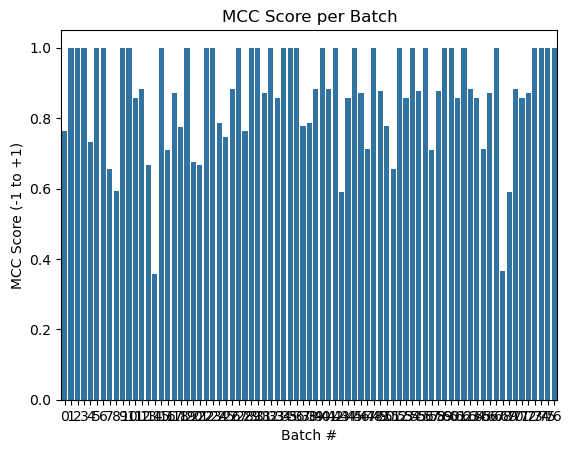

In [62]:
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, errorbar=None)
plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')
plt.show()

In [63]:
flat_predictions = np.concatenate(predictions, axis = 0)
flat_predictions = np.argmax(flat_predictions, axis = 1).flatten()
flat_true_labels = np.concatenate(true_labels, axis = 0)
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('Total MCC:%.3f' %mcc)

Total MCC:0.871


In [64]:
# txt = input('Enter the news description..')

In [65]:
# pattern = re.compile(r"[!@#$(),\n\"%^*?:;~\[\]]")  

# def text_preprocessing(text):
#     data_list = []
    
#     words = text.split()
#     for word in words:
#         new_word = pattern.sub("", word).lower().strip()
#         if "'" in new_word:
#             new_word = new_word.replace("'", "")
#         if new_word and new_word not in stopwords and len(new_word) > 2 :  
#             data_list.append(new_word)

#     return " ".join(data_list)

In [78]:
with open('utils/models/fakenews_detection.pkl', 'wb') as fake_news:
    pickle.dump(model, fake_news)

In [66]:
# def predict_news(model, input_ids = [], attention_mask = [], text):
#     X = text_preprocessing(text)
#     input_ids, attention_mask = tokenization(X, input_ids, attention_mask)
#     input_ids = input_ids['input_ids'].to(device)
#     attention_mask = attention_mask['attention_mask'].to(device)
    
#     model.eval()
#     with torch.no_grad():
#         outputs = model(input_ids, attention_mask=attention_mask)
    
#     logits = outputs.logits
#     probabilities = torch.nn.functional.softmax(logits, dim = 1)
    
#     predicted_class = torch.argmax(probabilities, dim=1).item()
#     return predicted_class, probabilites.cpu().numpy()

SyntaxError: parameter without a default follows parameter with a default (2770928008.py, line 1)

In [ ]:
# predicted_label, probs = predicted_news(model, input_ids, attention_mask)

# print(f"Predicted Label: {'Fake' if predicted_label == 1 else 'Real'}")
# print(f"Probabilities: {probs}")